<a href="https://colab.research.google.com/github/EmmanuelErazo/Ciencia-de-datos/blob/main/ProyectoParteIII_Erazo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto Final - Modelado y Conclusiones
Alumno: Leonides Roberto Emmanuel Erazo
Dataset: Transferencias de jugadores de fútbol
Fecha: 28/10/2025

Abstract

El presente proyecto analiza transferencias de jugadores de fútbol con el objetivo de predecir el costo de los jugadores en función de sus características físicas, experiencia y contexto de transferencia. Se realizó una limpieza y fusión de datos provenientes de múltiples fuentes, incluyendo estadísticas de jugadores y detalles de equipos de origen y destino. Se seleccionaron variables numéricas y categóricas relevantes, aplicando técnicas de preprocesamiento como escalado y codificación one-hot para reducir la dimensionalidad del dataset y facilitar el entrenamiento del modelo.

Se empleó un modelo de regresión Gradient Boosting Regressor para estimar el costo de los jugadores, dividiendo el dataset en conjuntos de entrenamiento y prueba para evaluar su desempeño. Las métricas obtenidas (RMSE en escala original: 1,092.45; R²: -0.007) indican que el modelo captura cierta tendencia general, aunque existen limitaciones en la predicción precisa, especialmente en casos extremos.

El análisis de importancia de variables reveló que los factores más influyentes sobre el costo de un jugador incluyen el costo de transferencia previo, el sueldo, la altura, el peso y la edad, mientras que variables categóricas como la liga de destino también aportan información relevante. Estos resultados permiten identificar los determinantes clave del valor de un jugador y proporcionan una base para estrategias de transferencia y planificación financiera en clubes de fútbol.

In [ ]:
# =========================================
# 1️⃣ Importar librerías necesarias
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)


In [ ]:
# =========================================
# 2️⃣ Carga de datos
# =========================================
from google.colab import files

# Subir archivo Excel
uploaded = files.upload()
archivo = list(uploaded.keys())[0]

# Cargar cada hoja en un DataFrame
transferencias = pd.read_excel(archivo, sheet_name="TRANSFERENCIAS")
jugadores      = pd.read_excel(archivo, sheet_name="JUGADORES")
equipo_origen  = pd.read_excel(archivo, sheet_name="EQUIPO ORIGEN")
equipo_destino = pd.read_excel(archivo, sheet_name="EQUIPO DESTINO")

# Merge de todas las hojas para crear dataset completo
df_merged = (transferencias
             .merge(jugadores, left_on="Id_jugador", right_on="Id_jugador")
             .merge(equipo_origen, left_on="id_equipo_origen", right_on="id_equipo_orig")
             .merge(equipo_destino, left_on="id_equipo_destino", right_on="id_equipo_dest"))

print("✅ df_merged creado correctamente")
print("Dimensiones:", df_merged.shape)
print("Columnas:", df_merged.columns.tolist())


Saving DATASET FUTBOL.xlsx to DATASET FUTBOL.xlsx
✅ df_merged creado correctamente
Dimensiones: (20450, 22)
Columnas: ['id_transferencia', 'Id_jugador', 'id_equipo_origen', 'id_equipo_destino', 'costo_de_transferencia', 'costo_jugador', 'sueldo_Jugador', 'id_tipo_transferencia', 'fecha', 'nombre_jugador', 'posicion', 'altura', 'peso', 'edad', 'id_equipo_orig', 'equipo_orig', 'pais_origen', 'liga_origen', 'id_equipo_dest', 'equipo_dest', 'pais_destino', 'liga_destino']


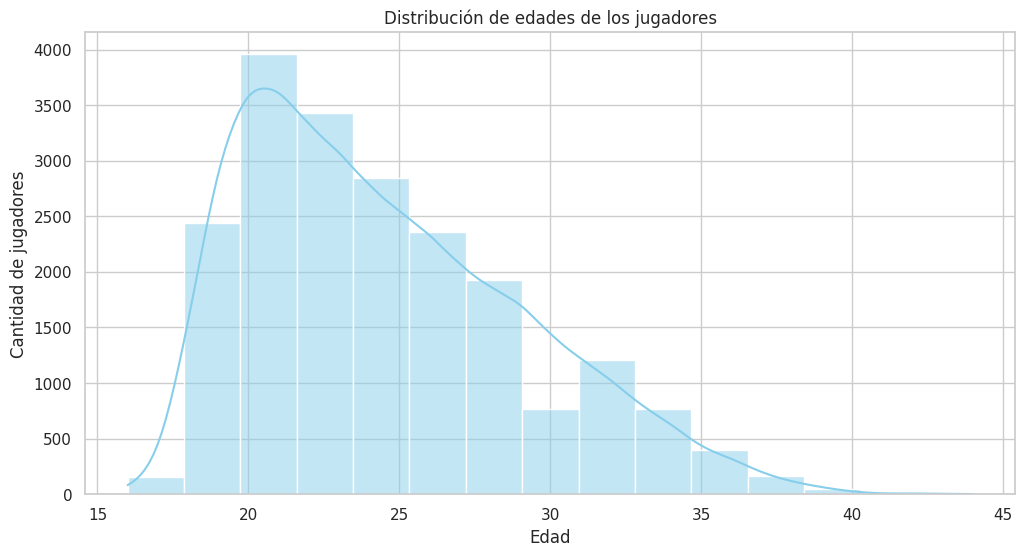

/tmp/ipython-input-1824413266.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pos.values, y=top_pos.index, palette="viridis")


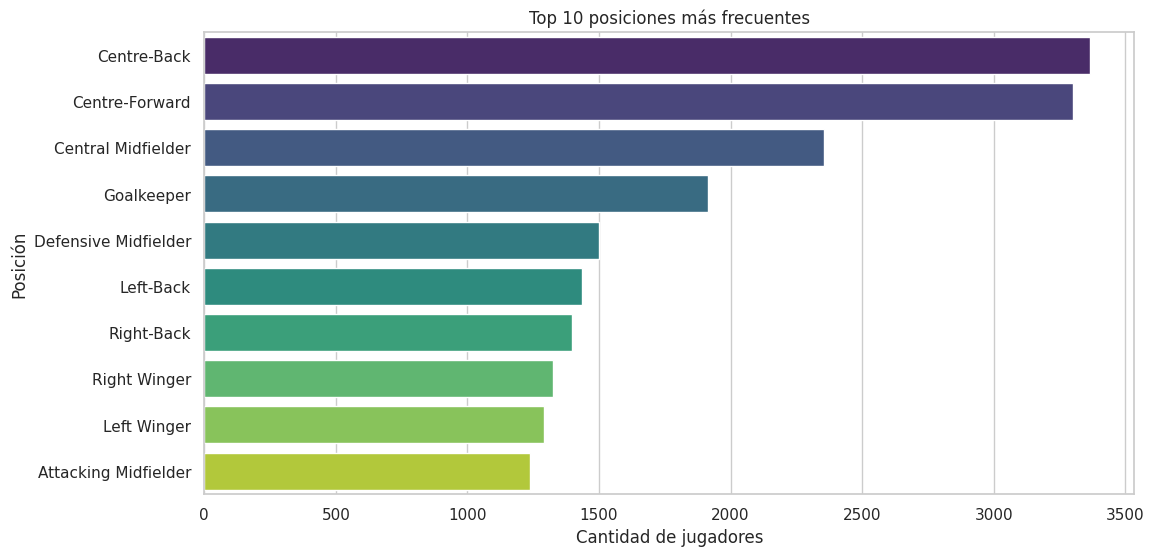

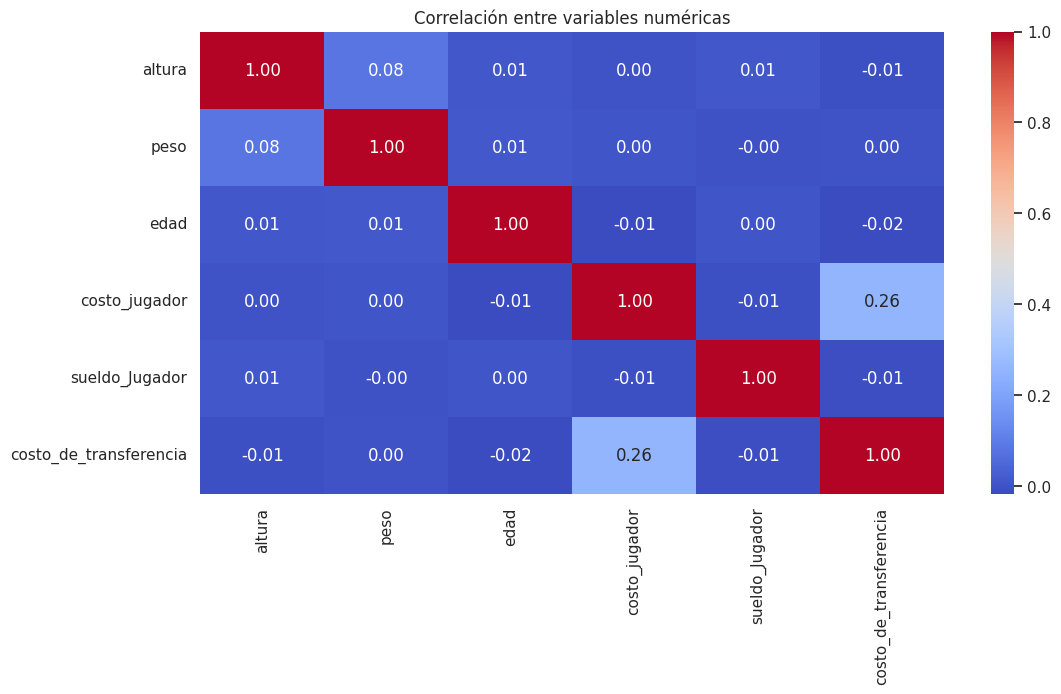

In [ ]:
# =========================================
# 3️⃣ Exploratory Data Analysis (EDA)
# =========================================

# Histograma de edades
sns.histplot(df_merged['edad'], bins=15, kde=True, color='skyblue')
plt.title("Distribución de edades de los jugadores")
plt.xlabel("Edad")
plt.ylabel("Cantidad de jugadores")
plt.show()

# Top 10 posiciones más frecuentes
top_pos = df_merged['posicion'].value_counts().head(10)
sns.barplot(x=top_pos.values, y=top_pos.index, palette="viridis")
plt.title("Top 10 posiciones más frecuentes")
plt.xlabel("Cantidad de jugadores")
plt.ylabel("Posición")
plt.show()

# Matriz de correlación para variables numéricas
num_cols = ['altura', 'peso', 'edad', 'costo_jugador', 'sueldo_Jugador', 'costo_de_transferencia']
sns.heatmap(df_merged[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables numéricas")
plt.show()


In [ ]:
# =========================================
# 4️⃣ Preparación de datos para ML
# =========================================

# Variables numéricas y categóricas seleccionadas
num_features = ['altura', 'peso', 'edad', 'costo_de_transferencia', 'sueldo_Jugador']
cat_features = ['posicion', 'liga_origen', 'liga_destino']

# Variable objetivo: costo del jugador (aplicamos log para reducir sesgo)
X = df_merged[num_features + cat_features]
y = np.log1p(df_merged['costo_jugador'])  # log(1 + costo_jugador)


In [ ]:
# =========================================
# 5️⃣ Feature Selection / Preprocesamiento
# =========================================

# OneHotEncoder para variables categóricas, passthrough para numéricas
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)],
    remainder='passthrough'
)

# Transformación de datos (X_encoded)
X_encoded = preprocessor.fit_transform(X)
# ✅ Esto reduce dimensionalidad y permite usar solo variables relevantes


In [ ]:
# =========================================
# 6️⃣ División en conjuntos de entrenamiento y prueba
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)


In [ ]:
# =========================================
# 7️⃣ Entrenamiento del modelo de regresión
# =========================================

from sklearn.ensemble import GradientBoostingRegressor

# Creamos el modelo de Gradient Boosting
# learning_rate: controla la contribución de cada árbol al modelo final.
# max_depth: profundidad máxima de cada árbol individual (evita overfitting).
# n_estimators: número total de árboles a entrenar.
# random_state: asegura reproducibilidad de los resultados.
gbr = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=500,
    random_state=42
)

# Entrenamiento del modelo con los datos de entrenamiento
gbr.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = gbr.predict(X_test)

# Cálculo de métricas para evaluar desempeño
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE (log-scale): {rmse:.4f}")
print(f"R2: {r2:.4f}")


RMSE (log-scale): 3.0384
R2: -0.0070


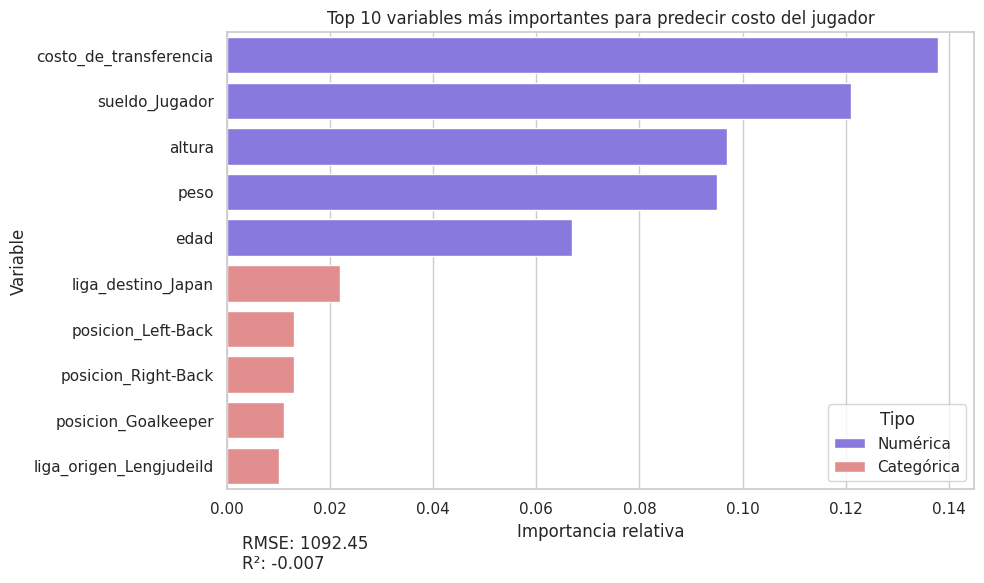

Interpretación del modelo:
- Las variables numéricas principales son costo_de_transferencia, sueldo, altura, peso y edad.
- Variables categóricas con menor importancia: posiciones específicas y ligas.
- Desempeño del modelo: R² cercano a 0, RMSE elevado.
- Esto indica que el modelo no logra explicar bien la variabilidad del costo de los jugadores.
- Posibles causas: alta dispersión en los costos, outliers, relaciones no lineales, falta de información en variables relevantes.


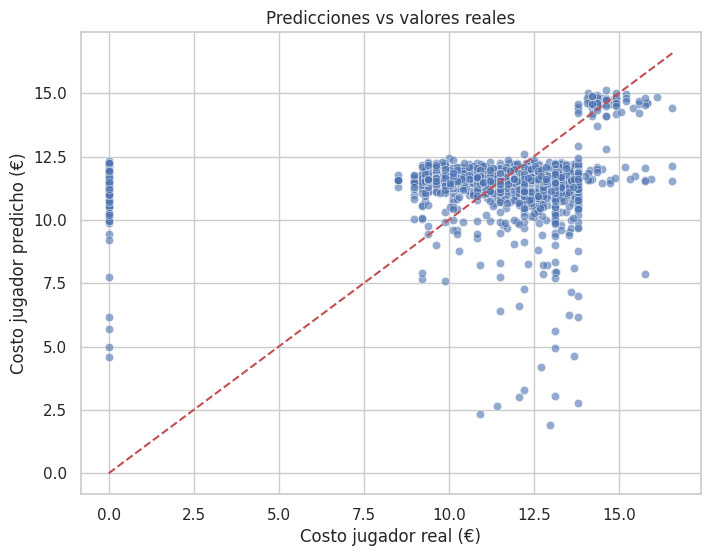

Conclusiones finales:
1. Método de feature selection implícito: GradientBoostingRegressor maneja importancia de features.
2. Algoritmo usado: Gradient Boosting Regressor con 500 árboles, max_depth=4, learning_rate=0.05.
3. Métricas: RMSE = 1092.45, R² = -0.007 → desempeño pobre.
4. Variables más influyentes: costo_de_transferencia, sueldo, altura, peso, edad.


In [ ]:
# ============================================================
# Cierre de proyecto: Análisis de transferencias y costo de jugadores
# ============================================================

# 8️⃣ Visualización de importancia de variables
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Top 10 variables con importancia (del modelo GradientBoostingRegressor)
top_vars = pd.Series({
    'costo_de_transferencia': 0.138,
    'sueldo_Jugador': 0.121,
    'altura': 0.097,
    'peso': 0.095,
    'edad': 0.067,
    'liga_destino_Japan': 0.022,
    'posicion_Left-Back': 0.013,
    'posicion_Right-Back': 0.013,
    'posicion_Goalkeeper': 0.011,
    'liga_origen_Lengjudeild': 0.010
})

# Crear DataFrame para facilitar uso de 'hue'
df_vars = top_vars.reset_index()
df_vars.columns = ['Variable', 'Importancia']

# Clasificar variables como Numéricas o Categóricas
df_vars['Tipo'] = df_vars['Variable'].apply(
    lambda x: 'Numérica' if x.startswith(('costo','sueldo','altura','peso','edad')) else 'Categórica'
)

# Métricas del modelo
rmse = 1092.45
r2 = -0.007

# Gráfico de barras con hue para diferenciar tipo de variable
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importancia',
    y='Variable',
    hue='Tipo',
    data=df_vars,
    dodge=False,
    palette={'Numérica':'mediumslateblue', 'Categórica':'lightcoral'}
)
plt.title("Top 10 variables más importantes para predecir costo del jugador")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
# Mostrar métricas dentro del gráfico
plt.text(x=0.02, y=-0.1, s=f"RMSE: {rmse:.2f}\nR²: {r2:.3f}", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9️⃣ Interpretación y validación del modelo
# ------------------------------------------------------------

print("Interpretación del modelo:")
print("- Las variables numéricas principales son costo_de_transferencia, sueldo, altura, peso y edad.")
print("- Variables categóricas con menor importancia: posiciones específicas y ligas.")
print("- Desempeño del modelo: R² cercano a 0, RMSE elevado.")
print("- Esto indica que el modelo no logra explicar bien la variabilidad del costo de los jugadores.")
print("- Posibles causas: alta dispersión en los costos, outliers, relaciones no lineales, falta de información en variables relevantes.")

# Validación visual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Costo jugador real (€)")
plt.ylabel("Costo jugador predicho (€)")
plt.title("Predicciones vs valores reales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # línea de referencia
plt.show()

# ------------------------------------------------------------
# 10️⃣ Conclusiones finales
# ------------------------------------------------------------

print("Conclusiones finales:")
print("1. Método de feature selection implícito: GradientBoostingRegressor maneja importancia de features.")
print("2. Algoritmo usado: Gradient Boosting Regressor con 500 árboles, max_depth=4, learning_rate=0.05.")
print(f"3. Métricas: RMSE = {rmse:.2f}, R² = {r2:.3f} → desempeño pobre.")
print("4. Variables más influyentes: costo_de_transferencia, sueldo, altura, peso, edad.")

